## Plotting

In [1]:
import os
os.umask(0o002)

# H5 File bug over network file system.
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

import torch
import torch.nn as nn
from math import sqrt

import torch.nn.functional as F
from models import NetSO2, Net, NetTMBasis, rad_bases
from ComplexNetsnoTF import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)

In [3]:
class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

class Net(nn.Module):
    def __init__(self, layers=6):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, layers)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

mod_SR = Net(6)

In [4]:
mod_1 = NetTMBasis(TM_name='TheoryTM_256')


In [5]:
checkpoint = torch.load(f'outputs/paper_theory_imagenet_orig_tmbases_datav2_v3_SR/mod1_400.tar')
mod_SR.load_state_dict(checkpoint['model_SR_state_dict'])
checkpoint = torch.load(f'outputs/paper_theory_imagenet_orig_tmbases_datav2_v3/mod1_200.tar')
mod_1.load_state_dict(checkpoint['model_1_state_dict'])

mod_1.eval()
mod_SR.eval()


Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
  )
  (input): Conv2d

In [6]:
data_path = f'data/TheoryTM_imagenette_grey_v2/'
file_location = f'test_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_test = np.array(f['original'])
    speckled_imgs_test = np.array(f['speckled'], dtype=np.csingle)
#     inverted_imgs_test = np.array(f['inverted'], dtype=np.csingle)
    
original_imgs_max = np.max(original_imgs_test)
original_imgs_min = np.min(original_imgs_test)
print(f'original_imgs_max : {original_imgs_max}')
print(f'original_imgs_min : {original_imgs_min}')
speckled_imgs_max = np.max(speckled_imgs_test)
speckled_imgs_min = np.min(speckled_imgs_test)
print(f'speckled_imgs_max : {speckled_imgs_max}')
print(f'speckled_imgs_min : {speckled_imgs_min}')

Keys: <KeysViewHDF5 ['inverted', 'original', 'speckled']>
original_imgs_max : 1.0
original_imgs_min : 0.0
speckled_imgs_max : (1.9821763038635254-0.7558392882347107j)
speckled_imgs_min : (-2.702416181564331+1.059789776802063j)


In [8]:
data_path = f'data/TheoryTM_imagenette_grey_v2/'
file_location = f'train_data.h5'
with h5py.File( data_path + file_location , 'r') as f:
    print("Keys: %s" % f.keys())
    original_imgs_train = np.array(f['original'])#[:80]
    speckled_imgs_train = np.array(f['speckled'], dtype=np.csingle)#[:80]
#     inverted_imgs_train = np.array(f['inverted'], dtype=np.csingle)


Keys: <KeysViewHDF5 ['inverted', 'original', 'speckled']>


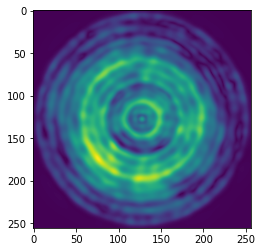

In [9]:
plt.imshow(np.abs(speckled_imgs_test[2]))

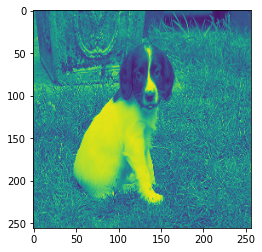

In [10]:
plt.imshow(original_imgs_test[2])

In [11]:
mod_1 = mod_1.cuda()
mod_SR = mod_SR.cuda()


In [12]:
# print(f'Trainable params (mil) : {sum(p.numel() for p in mod_mlp.parameters() if p.requires_grad)/1000000}')
# print(f'Params (mil) : {sum(p.numel() for p in mod_mlp.parameters())/1000000}')

print(f'Trainable params (mil) : {sum(p.numel() for p in mod_1.parameters() if p.requires_grad)/1000000}')
print(f'Params (mil) : {sum(p.numel() for p in mod_1.parameters())/1000000}')

print(f'Trainable params (mil) : {sum(p.numel() for p in mod_SR.parameters() if p.requires_grad)/1000000}')
print(f'Params (mil) : {sum(p.numel() for p in mod_SR.parameters())/1000000}')



Trainable params (mil) : 0.001061
Params (mil) : 69.534757
Trainable params (mil) : 0.222336
Params (mil) : 0.222336


In [13]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
    predicted_img = predicted_img.view(-1,1,256,256)
    predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

tot_loss = 0
for original_img, speckled_img in zip(original_imgs_train,speckled_imgs_train):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
    predicted_img = predicted_img.view(-1,1,256,256)
    predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

0.0451240415021283
0.04338570873902916


In [14]:
tot_loss = 0
for original_img, speckled_img in zip(original_imgs_test,speckled_imgs_test):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
#     predicted_img = predicted_img.view(-1,1,256,256)
#     predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_test))

tot_loss = 0
for original_img, speckled_img in zip(original_imgs_train,speckled_imgs_train):
    original_img = torch.from_numpy(original_img).cuda()
    original_img = torch.unsqueeze(original_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=1)
    speckled_img = torch.from_numpy(speckled_img).cuda()
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    speckled_img = torch.unsqueeze(speckled_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)
    
    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_img = torch.abs(predicted_inv_img)
    
#     predicted_img = predicted_img.view(-1,1,256,256)
#     predicted_img = mod_SR(predicted_img)

    original_img = original_img.view(1,-1)
    predicted_img = predicted_img.view(1,-1)

    loss = F.mse_loss(predicted_img, original_img)
    tot_loss += loss.item()
print(tot_loss/len(speckled_imgs_train))

0.06265825640644263
0.0594062049592617


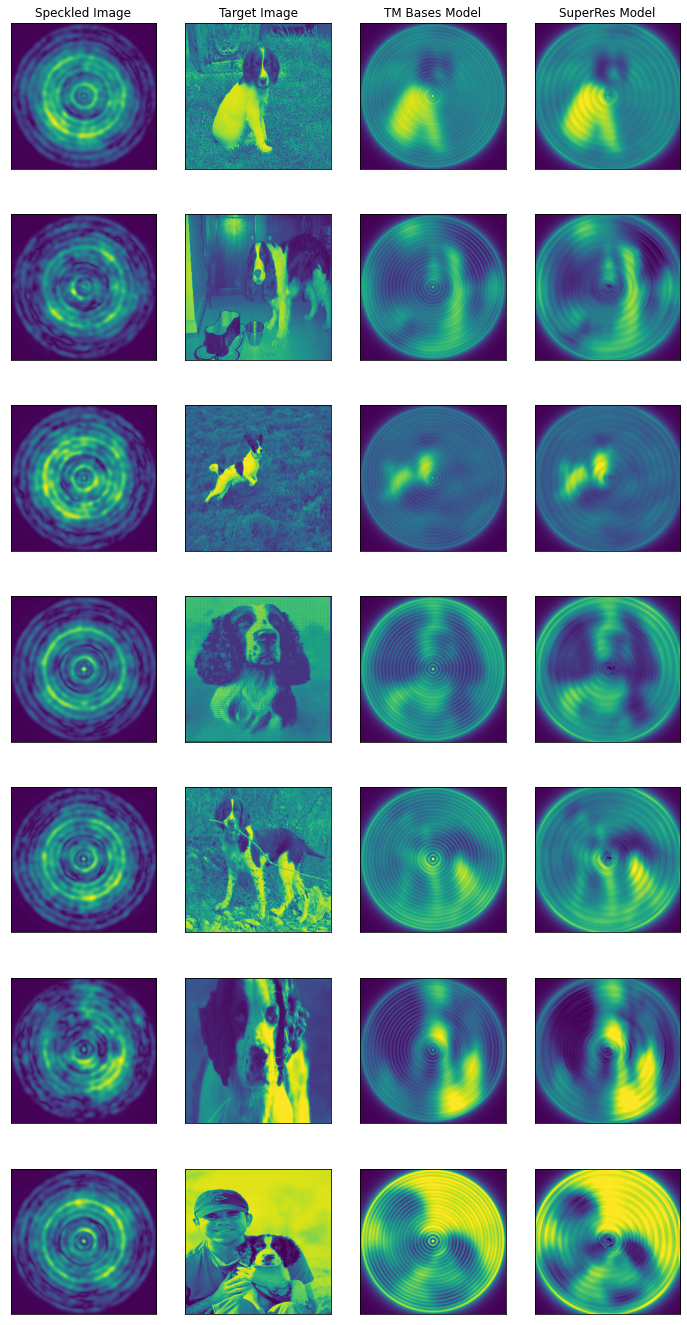

In [15]:
img_nums = [2,3,5,7,8,9,12]
f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(12,24))
for i, img_num in enumerate(img_nums):
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=0)

    speckled_img = torch.unsqueeze(speckled_img, dim=1)
    original_img = torch.unsqueeze(original_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)

    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_inv_img = torch.abs(predicted_inv_img)
#     predicted_inv_img = predicted_inv_img /255.0
    
    predicted_inv_img2 = predicted_inv_img.view(-1,1,256,256)
    predicted_img = mod_SR(predicted_inv_img2)#.cpu()
    
#     original_img = original_img.cpu()
#     speckled_img = speckled_img.cpu()
    
    speckled_img = speckled_img.view(256,256).detach().cpu().numpy()
    original_img = original_img.view(256,256).detach().cpu().numpy()
    predicted_inv_img = predicted_inv_img.view(256,256).detach().cpu().numpy()
    predicted_img = predicted_img.view(256,256).detach().cpu().numpy()
    
#     f, ax_arr = plt.subplots(1, 3, figsize=(20, 13))
    plt.subplot(len(img_nums), 4, 1 + (i*4))
#     plt.imshow(inverted_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
    plt.imshow(np.abs(speckled_img))#, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Speckled Image')
    plt.subplot(len(img_nums), 4, 2 + (i*4))
#     plt.imshow(original_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
    plt.imshow(original_img, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'Target Image')
    plt.subplot(len(img_nums), 4, 3 + (i*4))
#     plt.imshow(predicted_img.view(256,256).detach().cpu().numpy(), cmap='gray_r')
    plt.imshow(np.abs(predicted_inv_img), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i==0:
        plt.title(f'TM Bases Model')
    plt.subplot(len(img_nums), 4, 4 + (i*4))
    plt.imshow(predicted_img, vmin=0, vmax=1)
    axes_off()
    plt.yticks([])
    if i==0:
        plt.title(f'SuperRes Model')
#     plt.subplot(len(img_nums), 5, 5 + (i*5))
# #     plt.imshow(original_img-predicted_img)
# #     axes_off()
# #     plt.yticks([])
#     if i==0:
#         plt.title(f'Model w TM bases')
    
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.01,hspace=0.01)
# plt.savefig(f'outputs/imagenette_compare_results_inverted_img.pdf')
plt.show()

/tmp/ipykernel_34806/104957922.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


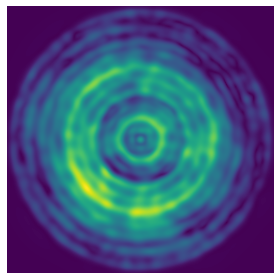

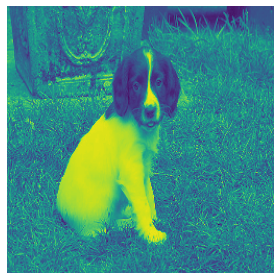

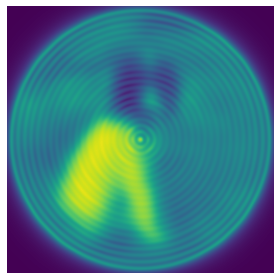

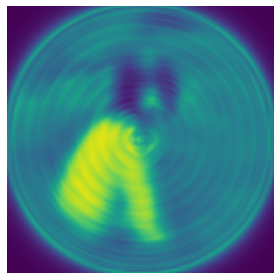

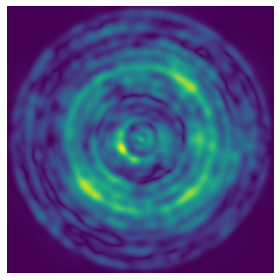

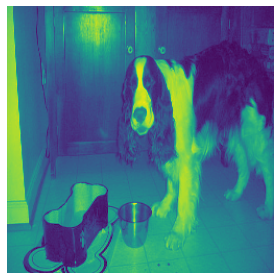

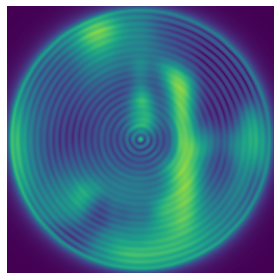

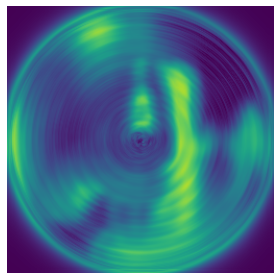

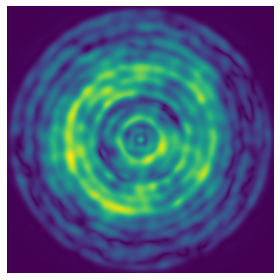

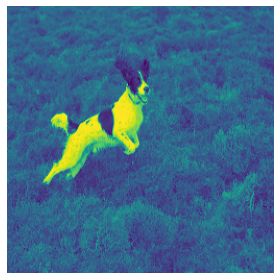

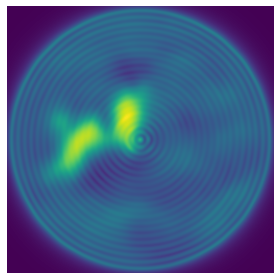

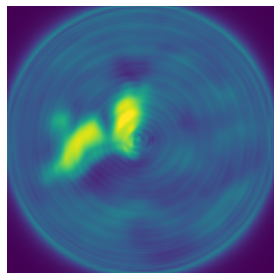

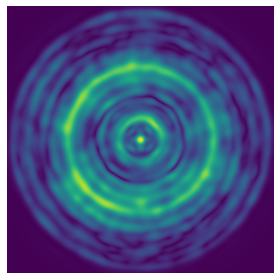

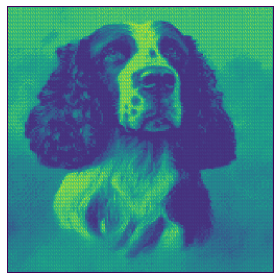

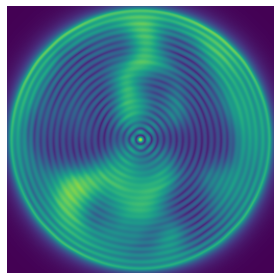

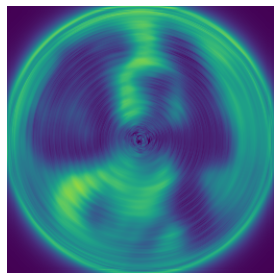

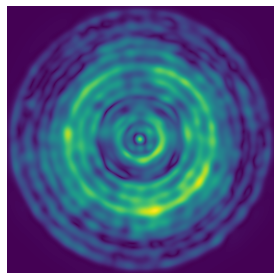

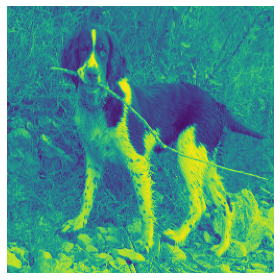

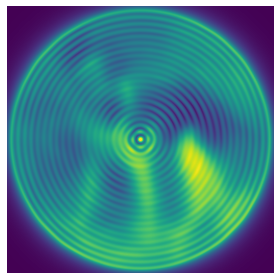

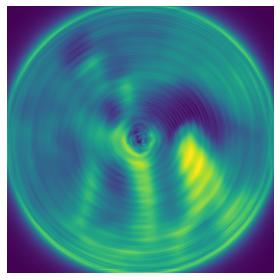

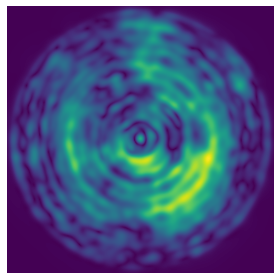

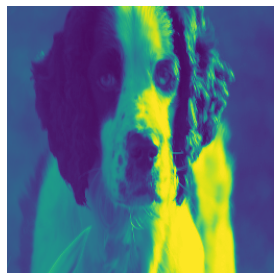

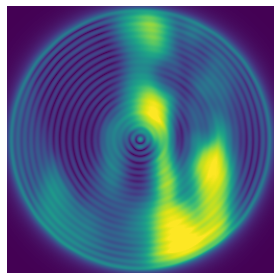

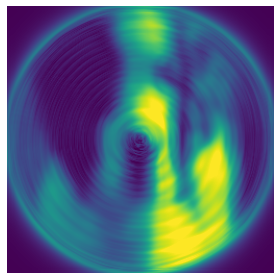

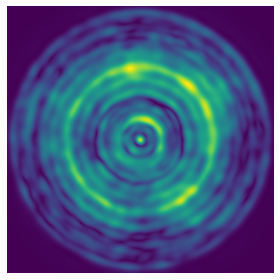

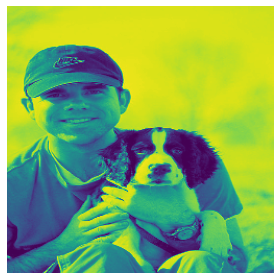

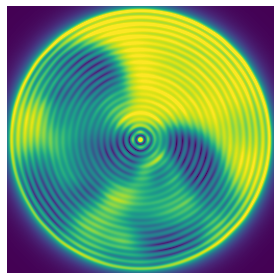

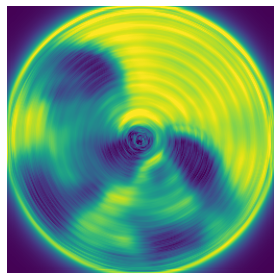

In [40]:
img_nums = [2,3,5,7,8,9,12]
# f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(12,24))
for i, img_num in enumerate(img_nums):
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=0)

    speckled_img = torch.unsqueeze(speckled_img, dim=1)
    original_img = torch.unsqueeze(original_img, dim=1)

    speckled_img = speckled_img.view(speckled_img.shape[0], -1)

    ## Pass image through model
    predicted_inv_img = mod_1(speckled_img)
    predicted_inv_img = torch.abs(predicted_inv_img)
#     predicted_inv_img = predicted_inv_img /255.0
    
    predicted_inv_img2 = predicted_inv_img.view(-1,1,256,256)
    predicted_img = mod_SR(predicted_inv_img2)#.cpu()
    
#     original_img = original_img.cpu()
#     speckled_img = speckled_img.cpu()
    
    speckled_img = speckled_img.view(256,256).detach().cpu().numpy()
    original_img = original_img.view(256,256).detach().cpu().numpy()
    predicted_inv_img = predicted_inv_img.view(256,256).detach().cpu().numpy()
    predicted_img = predicted_img.view(256,256).detach().cpu().numpy()

    fig = plt.figure()
    plt.imshow(np.abs(speckled_img))#, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/speckled_{i}_300train.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(original_img, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/original_{i}_300train.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(predicted_inv_img), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/TM_bases_{i}_300train.pdf', bbox_inches='tight', pad_inches=0)
        
    fig = plt.figure()
    plt.imshow(predicted_img, vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/TM_bases_SR_{i}_300train.pdf', bbox_inches='tight', pad_inches=0)


## Save some plots of original, inverted, and speckled images

/tmp/ipykernel_474/2870160245.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


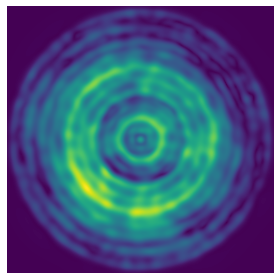

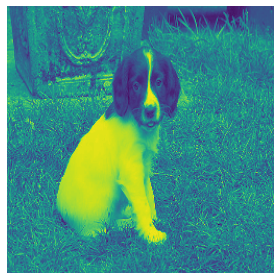

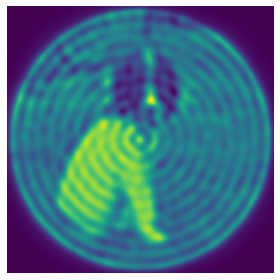

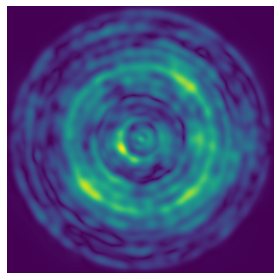

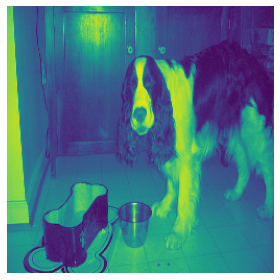

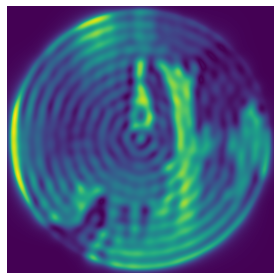

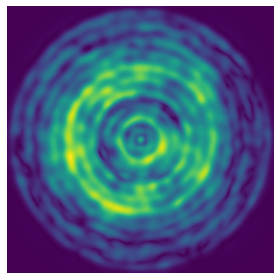

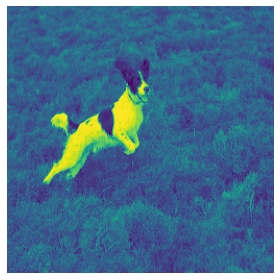

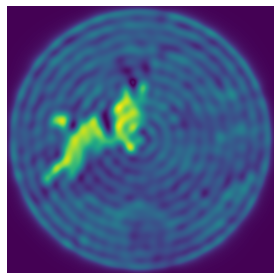

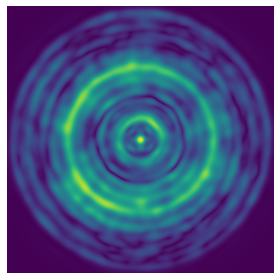

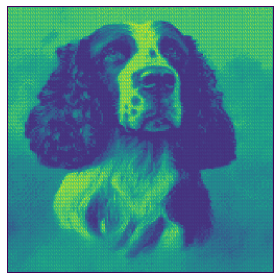

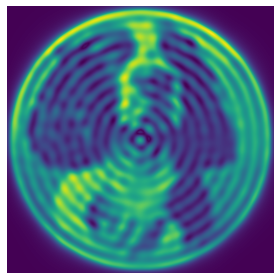

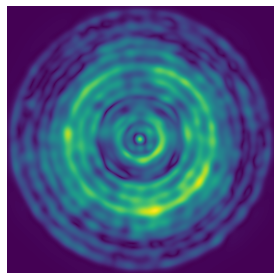

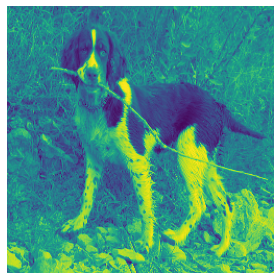

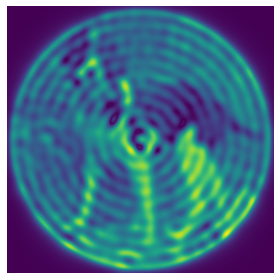

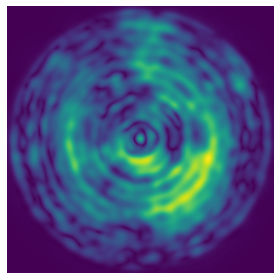

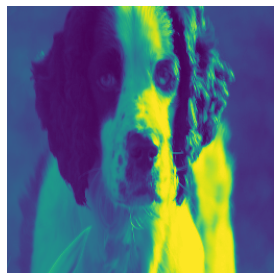

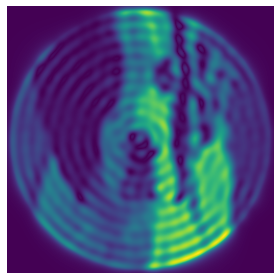

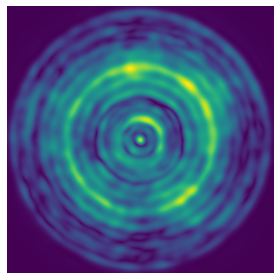

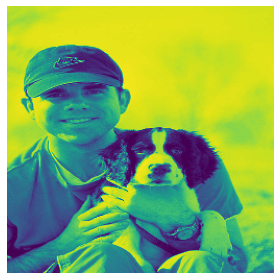

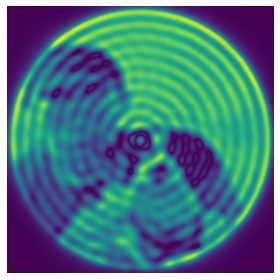

In [4]:
img_nums = [2,3,5,7,8,9,12]
# f, ax_arr = plt.subplots(len(img_nums), 5, figsize=(12,24))
for i, img_num in enumerate(img_nums):
    speckled_img = torch.from_numpy(speckled_imgs_test[img_num]).to('cuda')
    original_img = torch.from_numpy(original_imgs_test[img_num]).to('cuda')
    inverted_img = torch.from_numpy(inverted_imgs_test[img_num]).to('cuda')
    
    speckled_img = torch.unsqueeze(speckled_img, dim=0)
    original_img = torch.unsqueeze(original_img, dim=0)
    inverted_img = torch.unsqueeze(inverted_img, dim=0)

    speckled_img = torch.unsqueeze(speckled_img, dim=1)
    original_img = torch.unsqueeze(original_img, dim=1)
    inverted_img = torch.unsqueeze(inverted_img, dim=1)

    speckled_img = speckled_img.view(256,256).detach().cpu().numpy()
    original_img = original_img.view(256,256).detach().cpu().numpy()
    inverted_img = inverted_img.view(256,256).detach().cpu().numpy()

    fig = plt.figure()
    plt.imshow(np.abs(speckled_img))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/speckled_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(original_img)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/original_{i}.pdf', bbox_inches='tight', pad_inches=0)
    
    fig = plt.figure()
    plt.imshow(np.abs(inverted_img))
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.tight_layout()
    plt.savefig(f'outputs/figures/imagenet/inverted_{i}.pdf', bbox_inches='tight', pad_inches=0)
